## Visual Bag of Words

For each of our classes, we compute the SIFT features and k-means cluster in order to get our "visual words". 

1) First we provide the directory of our images and split our dataset into train and testing data.

In [1]:
#Import necessary libraries
import phow_caltech101 as phow
from datetime import datetime
from os.path import exists
from sklearn.kernel_approximation import AdditiveChi2Sampler
from cPickle import dump, load
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
import pylab as pl

#Define initial configuration setup variables
IMAGEDIRECTORY = '101_ObjectCategories' #ATTENTION: SET IMAGE DIRECTORY HERE, MUST BE IN SAME FOLDER AS NOTEBOOK
IDENTIFIER = 'newBatch' #The identifier is a string that we use to cache our datasets with - using an identifier allows us to retrieve things from our cache later
OVERWRITE = False #Ignore the cache?
NUMTRAIN = 15 #From each directory, how many images do we want to train with to find our visual words
NUMTEST = 15 #From each directory, how many images do we want to use to test how good our visual words clustering is
NUMCLASSES = 102 #How many folders do we have, aka how many visual word clusterings do we have to do
NUMWORDS = 600 #How many words do we want to use to describe our image classes

conf = phow.Configuration(IDENTIFIER)
conf.setImagePath(IMAGEDIRECTORY)
conf.setNumTrain(NUMTRAIN)
conf.setNumTest(NUMTEST)
conf.setNumClasses(NUMCLASSES)
conf.setNumWords(NUMWORDS)

print str(datetime.now()) + '| Finished configuring system'

classes = phow.get_classes(conf.calDir, conf.numClasses)

model = phow.Model(classes, conf)

all_images, all_images_class_labels = phow.get_all_images(classes, conf)
selTrain, selTest = phow.create_split(all_images, conf)

print str(datetime.now()) + '| Found classes and created split'

2016-12-07 02:09:14.014887| Finished configuring system
2016-12-07 02:09:14.038074| Found classes and created split


We now use our selTrain data set and find our visual bag of words, we've specified to find 600 visual words.

In [4]:
##################
# Train vocabulary
##################
print str(datetime.now()) + '| Start training vocabulary - launching threads to do SIFT'
if (not exists(conf.vocabPath)) | OVERWRITE:
    vocab = phow.trainVocab(selTrain, all_images, conf)
    phow.savemat(conf.vocabPath, {'vocab': vocab})
else:
    print str(datetime.now()) + '| Done! Using old vocab from ' + conf.vocabPath
    vocab = phow.loadmat(conf.vocabPath)['vocab']

model.vocab = vocab #The columns of vocab are our visual words

2016-12-07 00:12:21.733933| Start training vocabulary - launching threads to do SIFT
2016-12-07 00:12:21.734093| Done! Using old vocab from tempresults/newBatch-vocab.py.mat


Calculate amount of "contribution" each word has to a specific image. (Imagine that the vocab is a set of singular vectors and we're computing our singular values.)

First, we pull out the SIFT vector from each image.

In [9]:
############################
# Compute spatial histograms
############################
print str(datetime.now()) + '| Computing Spatial Histograms'
if (not exists(conf.histPath)) | OVERWRITE:
    hists = phow.computeHistograms(all_images, model, conf, vocab)
    phow.savemat(conf.histPath, {'hists': hists})
else:
    print str(datetime.now()) + '| Found old historams at:' + conf.histPath
    hists = phow.loadmat(conf.histPath)['hists']

  0%|                                                                          |

2016-12-07 00:14:37.732420| Computing Spatial Histograms


100%|##########################################################################|


After that, we use the AdditiveChi2Sampler from sci-kit learn to do a feature mapping (analgously calculating the singular values).

In [11]:
#####################
# Compute feature map
#####################
print str(datetime.now()) + '| Computing Feature Map'
transformer = AdditiveChi2Sampler()
histst = transformer.fit_transform(hists)
train_data = histst[selTrain]
test_data = histst[selTest]

2016-12-07 00:44:59.932153| Computing Spatial Histograms


If we want, we can also naively classify what each image is with an SVM. We will use this method as a naive baseline to see how well our data programming approach works.

In [15]:
###########
# Train SVM
###########
if (not exists(conf.modelPath)) | OVERWRITE:
    print str(datetime.now()) + '| Training liblinear svm'

    clf = svm.LinearSVC(C=10) #C is the penalty parameter
    print clf
    
    clf.fit(train_data, all_images_class_labels[selTrain])
    
    with open(conf.modelPath, 'wb') as fp:
        dump(clf, fp)
else:
    print str(datetime.now()) + '| Loading old SVM model'
    with open(conf.modelPath, 'rb') as fp:
        clf = load(fp)

2016-12-07 00:47:18.978532| Training liblinear svm
LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


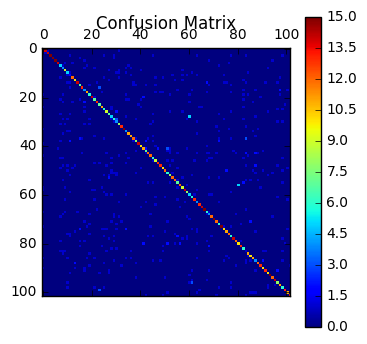

0.661437908497


In [34]:
##########
# Test SVM
##########
if (not exists(conf.resultPath)) | OVERWRITE:
    print str(datetime.now()) + '| Testing svm by outputting confusion matrix'
    predicted_classes = clf.predict(test_data)
    true_classes = all_images_class_labels[selTest]
    accuracy = accuracy_score(true_classes, predicted_classes)
    cm = confusion_matrix(predicted_classes, true_classes)
    with open(conf.resultPath, 'wb') as fp:
        dump(conf, fp)
        dump(cm, fp)
        dump(predicted_classes, fp)
        dump(true_classes, fp)
        dump(accuracy, fp)
else:
    with open(conf.resultPath, 'rb') as fp:
        conf = load(fp)
        cm = load(fp)
        predicted_classes = load(fp)
        true_classes = load(fp)
        accuracy = load(fp)
        
pl.matshow(cm)
pl.title('Confusion Matrix')
pl.colorbar()
pl.show()

print(accuracy)

As we can see in the confusion matrix, we get a decently good accuracy, around ~70%.

## Snorkel Installation and Setup

First, let's load snorkel into our Jupyter python path. For some reason, the snorkel installation doesn't always work so this is here as a backup. Make sure that you follow the installation instructions in the README as well before executing any code.

In [3]:
import os
import sys

#Set the correct environment variables
os.environ['SNORKELHOME']='/home/thomas/snorkel'
os.environ['PYTHONPATH']=':/home/thomas/snorkel:/home/thomas/snorkel/treedlib:/home/thomas/snorkel:/home/thomas/snorkel/treedlib'
os.environ['PATH']='/home/thomas/bin:/home/thomas/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/thomas/snorkel:/home/thomas/snorkel/treedlib:/home/thomas/snorkel:/home/thomas/snorkel/treedlib'

#Add python to the system path so that python can find the package
sys.path.append('/home/thomas/snorkel')
sys.path.append('/home/thomas/snorkel/treedlib')

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fitting the Generative Model
We estimate the accuracies of the labeling functions without supervision. Specifically, we estimate the parameters of a `NaiveBayes` generative model.

First, we have to specify a sparse matrix with labeling function output. The setup of the matrix is as follows:

Rows of the matrix correspond with individual test images
Columns of the matrix correspond to individual labeling functions
Entries in the matrix are {-1, 0, 1}, the possible outputs of each labeling function

In [7]:
#Setup our sparse array
import numpy as np
from scipy.sparse import csr_matrix
a = csr_matrix((3, 4), dtype=np.int8).toarray()

a[0,1] = 1

a

array([[0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int8)

In [8]:
#Convert our sparse array into a format that snorkel knows how to deal with
from snorkel.annotations import csr_LabelMatrix
from snorkel.annotations import csr_AnnotationMatrix

a1 = csr_LabelMatrix(csr_AnnotationMatrix(a))

a1

<3x4 sparse matrix of type '<type 'numpy.int8'>'
	with 1 stored elements in Compressed Sparse Row format>

In [11]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(a1, n_iter=1000, rate=1e-5)

gen_model.w

Training marginals (!= 0.5):	3
Features:			4
Begin training for rate=1e-05, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.000000
SGD converged for mu=1e-06 after 10 steps


array([ 0.999985,  0.999985,  0.999985,  0.999985])

In [14]:
train_marginals = gen_model.marginals(a1)

train_marginals

array([ 0.73105563,  0.5       ,  0.5       ])

In [ ]:
from snorkel.learning import LogReg
from snorkel.learning_utils import RandomSearch, ListParameter, RangeParameter

iter_param = ListParameter('n_iter', [250, 500, 1000, 2000])
rate_param = RangeParameter('rate', 1e-4, 1e-2, step=0.75, log_base=10)
reg_param  = RangeParameter('mu', 1e-8, 1e-2, step=1, log_base=10)

disc_model = LogReg()

In [ ]:
searcher = RandomSearch(disc_model, F_train, train_marginals, 10, iter_param, rate_param, reg_param)